In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import glob

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
module_path = os.path.join(os.environ['HOME'],'tools','a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind, covariance, power_spectral_density, theta
import assessment.studies.profile_assimilation_obs.helpers as helper

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT profile assimilation + obs study: Produce figures
written by [Dries Allaerts](mailto:dries.allaerts@nrel.gov)

Produce figures for the paper on profile assimilation with WRF. This notebook depends on:
- SOWFA simulation data: 10-min data and spectra averaged over 9 virtual tower, generated by `analyse_virtual_tower_data.ipynb`. The simulations were driven with
    - Observations (no temperature forcing)
    - Observations (using WRF temperature)
    - Observations (using WRF temperature advection)
    - Mesoscale profiles
- reference data:
    - WRF data, generated in `wrf_to_sowfa.ipynb`
    - TTU tower data, generated in `process_TTU_tower.ipynb`
    - TTU radar data, generated in `process_TTU_radar.ipynb`

Main directories on Eagle

In [6]:
datadir = '/projects/mmc/dallaert/profile_assimilation_obs/'
referencedir = '/projects/mmc/dallaert/referenceData/'

In [7]:
simulation_data = {
    'pat_obs_noT':'internal_pat_obs_sowfa_noT',
    'pat_obs_wrfT':'internal_pat_obs_sowfa_wrfT',
    'pat_obs_wrfTadv':'internal_pat_obs_sowfa_wrfTadv',
    'pat_wrf':'internal_pat_wrf_sowfa'
}

Reference data

In [8]:
#NetCDF file with WRF data at the SWiFT site generated in wrf_to_sowfa.ipynb, which can be found in
# a2e-mmc/assessment/studies/coupling_comparison/preprocessing/internal/
wrfdata = 'WRF_20131108-09.nc'

# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
towerdata_10min = 'TTU_tilt_corrected_20131108-09_10min.csv'
towerdata       = 'TTU_tilt_corrected_20131108-09.csv'

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
radardata = 'TTU_obs_QC_20131108.csv'

Heights and times at which spectra are computed

In [9]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 12:00:00',end='2013-11-09 11:00:00',freq='1h')

## 1. Load data

In [10]:
%%time
df_10min = {}
for sim in simulation_data.keys():
    print('Reading '+sim)
    # Read data
    df_10min[sim] = pd.read_csv(datadir+'virtualTowerData/'+simulation_data[sim]+'_10min.csv',parse_dates=True,
                                index_col=['datetime','height'])
    # Calculate quantities of interest
    helper.calc_QOIs(df_10min[sim])
    
# CPU times: user 399 ms, sys: 22.8 ms, total: 421 ms
# Wall time: 424 ms

Reading pat_obs_noT
Reading pat_obs_wrfT
Reading pat_obs_wrfTadv
Reading pat_wrf
CPU times: user 506 ms, sys: 59.9 ms, total: 566 ms
Wall time: 810 ms


In [11]:
%%time
df_spectra = {}
for sim in simulation_data.keys():
    print('Reading '+sim)
    df_spectra[sim] = pd.read_csv(datadir+'virtualTowerData/'+simulation_data[sim]+'_spectra.csv',parse_dates=True,
                                index_col=['datetime','height','frequency'])
    
# CPU times: user 1.72 s, sys: 127 ms, total: 1.85 s
# Wall time: 2.38 s

Reading pat_obs_noT
Reading pat_obs_wrfT
Reading pat_obs_wrfTadv
Reading pat_wrf
CPU times: user 2.2 s, sys: 137 ms, total: 2.33 s
Wall time: 2.85 s


## 2. Load reference data

In [12]:
wrf = helper.load_wrf_reference_data(os.path.join(referencedir,wrfdata))

In [13]:
radar_scan0, radar_scan1 = helper.load_radar_reference_data(os.path.join(referencedir,radardata))

In [14]:
%%time
tower_10min = helper.load_tower_reference_data(os.path.join(referencedir,towerdata_10min))
tower_spectra = helper.load_tower_reference_spectra(os.path.join(referencedir,towerdata),
                                                    spectra_times,spectra_heights,
                                                    interval='1h',window_size='30min')
# CPU times: user 12.6 s, sys: 1.19 s, total: 13.7 s
# Wall time: 13.8 s

CPU times: user 12.9 s, sys: 1.21 s, total: 14.2 s
Wall time: 14.4 s


## 3. Plot virtual tower data

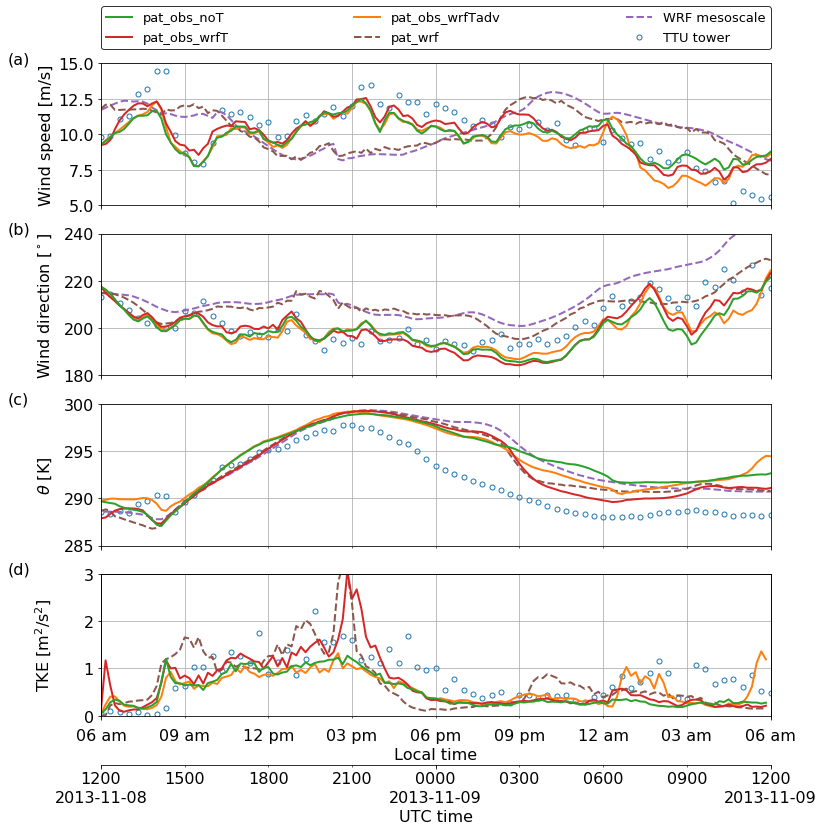

In [23]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets={
        'TTU tower': tower_10min,
        'WRF mesoscale': wrf,
        'pat_wrf': df_10min['pat_wrf'],
        'pat_obs_wrfTadv': df_10min['pat_obs_wrfTadv'],
        'pat_obs_wrfT': df_10min['pat_obs_wrfT'],
        'pat_obs_noT': df_10min['pat_obs_noT'],
    },
    fields = ['wspd','wdir','theta','TKE'],
    heights = 80,
    fieldlimits={
        'wspd':(5.,15.),
        'wdir':(180,240),
        'theta':(285,300),
        'TKE':(0,3)
    },
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    plot_local_time=True,
    local_time_offset=-6,
    labelsubplots=True,
    datasetkwargs={
        'TTU tower':{'linestyle':'','color':'#1f77b4','marker':'o','mfc':'none','markersize':5,'markevery':2},
        'WRF mesoscale':{'linestyle':'--','color':'#9467bd','linewidth':2},
        'pat_obs_wrfTadv':{'linestyle':'-','color':'#ff7f0e','linewidth':2},
        'pat_obs_wrfT':{'linestyle':'-','color':'#d62728','linewidth':2},
        'pat_obs_noT':{'linestyle':'-','color':'#2ca02c','linewidth':2},
        'pat_wrf':{'linestyle':'--','color':'#8c564b','linewidth':2},
    },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()


leg = ax[0].legend(handles[-1::-1],labels[-1::-1],loc='lower left',bbox_to_anchor=(0.0,1.1,1.0,0.0),
             borderaxespad=0,fontsize=13,ncol=3,mode='expand')
leg.get_frame().set_edgecolor('k')

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

#Save figure
figname = 'pat_obs_mean_timehistory'
plt.savefig(os.path.join(datadir,'Figures',figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.pdf'),bbox_inches='tight')

In [16]:
df_1h = {}
for sim in simulation_data:
    df_1h[sim] = df_10min[sim].unstack().resample('1h').mean().stack()

In [17]:
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

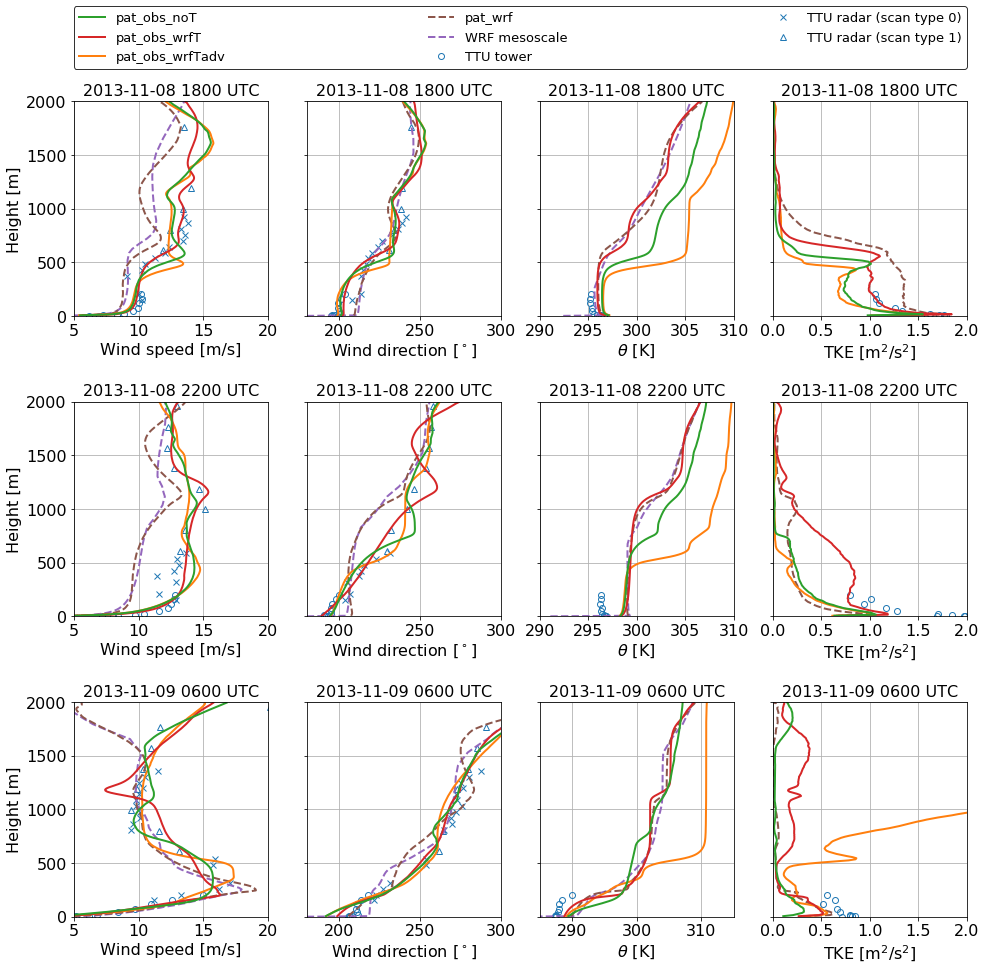

In [24]:
fig,ax = plot_profile(
    datasets={
        'TTU radar (scan type 1)':radar_scan1_1h,
        'TTU radar (scan type 0)':radar_scan0_1h,
        'TTU tower': tower_1h,
        'WRF mesoscale': wrf_1h,
        'pat_wrf': df_1h['pat_wrf'],
        'pat_obs_wrfTadv': df_1h['pat_obs_wrfTadv'],
        'pat_obs_wrfT': df_1h['pat_obs_wrfT'],
        'pat_obs_noT': df_1h['pat_obs_noT'],
    },
    fields=['wspd','wdir','theta','TKE'],
    fieldlimits={
        'wspd':(5.,20.),
        'wdir':(180,300),
        'theta':(290,310),
        'TKE':(0,2)
    },
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,2000),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'#1f77b4'},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6,'color':'#1f77b4'},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6,'color':'#1f77b4'},
                   'WRF mesoscale':{'linestyle':'--','color':'#9467bd','linewidth':2},
                   'pat_obs_wrfTadv':{'linestyle':'-','color':'#ff7f0e','linewidth':2},
                   'pat_obs_wrfT':{'linestyle':'-','color':'#d62728','linewidth':2},
                   'pat_obs_noT':{'linestyle':'-','color':'#2ca02c','linewidth':2},
                   'pat_wrf':{'linestyle':'--','color':'#8c564b','linewidth':2},
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

# Set temperature limits
ax[2,2].set_xlim([285,315])

#Place legend at the top
handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,3].get_legend().remove()

leg = fig.legend(handles[-1::-1], labels[-1::-1], loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')


#Save figure
figname = 'pat_obs_profiles'
plt.savefig(os.path.join(datadir,'Figures',figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.pdf'),bbox_inches='tight')

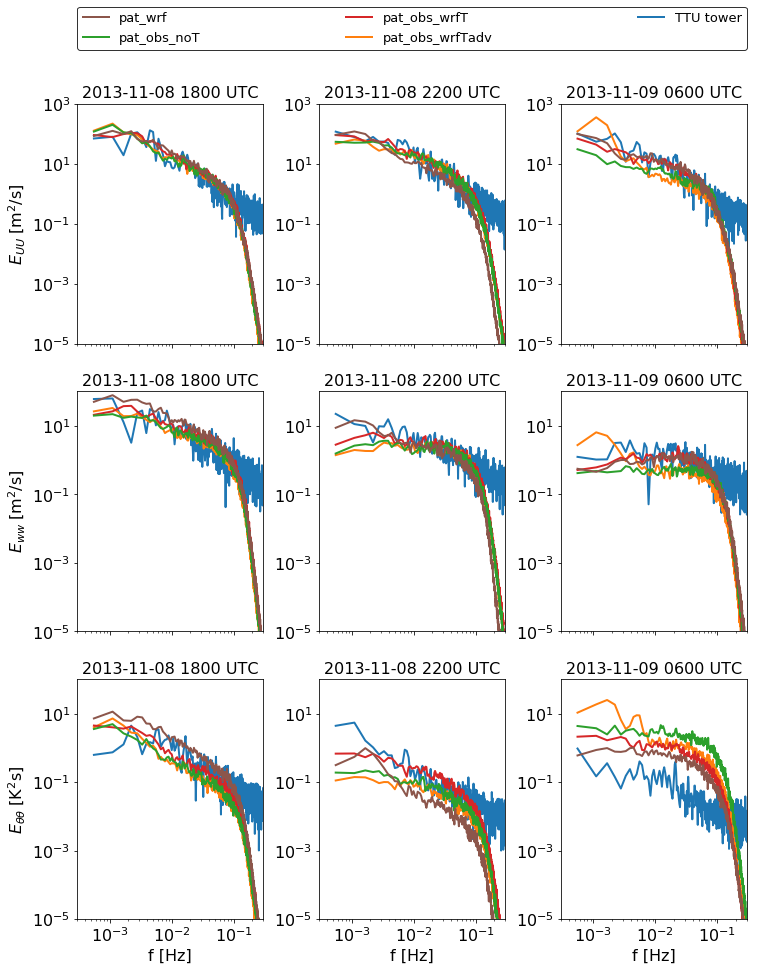

In [19]:
fig,ax = plot_spectrum(
    datasets={
        'TTU tower': tower_spectra,
        'pat_obs_wrfTadv': df_spectra['pat_obs_wrfTadv'],
        'pat_obs_wrfT': df_spectra['pat_obs_wrfT'],
        'pat_obs_noT': df_spectra['pat_obs_noT'],
        'pat_wrf': df_spectra['pat_wrf'],
    },
    height=80,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    fields=['wspd','w','theta'],
    freqlimits=(0.0003,0.3),
    fieldlimits={'wspd':(1.0e-5,1.0e3),'w':(1.0e-5,1.0e2),'theta':(1.0e-5,1.0e2)},
    datasetkwargs={
        'TTU tower':{'linestyle':'-','color':'#1f77b4','linewidth':2},
        'pat_obs_wrfTadv':{'linestyle':'-','color':'#ff7f0e','linewidth':2},
        'pat_obs_wrfT':{'linestyle':'-','color':'#d62728','linewidth':2},
        'pat_obs_noT':{'linestyle':'-','color':'#2ca02c','linewidth':2},
        'pat_wrf':{'linestyle':'-','color':'#8c564b','linewidth':2},
    },
)

#Place legend at the top
handles, labels = ax[0,2].get_legend_handles_labels()
ax[0,2].get_legend().remove()

leg = fig.legend(handles[-1::-1], labels[-1::-1], loc = 'lower left', bbox_to_anchor = (.125,.93,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')

#Save figure
figname = 'pat_obs_spectra'
plt.savefig(os.path.join(datadir,'Figures',figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(datadir,'Figures',figname+'.pdf'),bbox_inches='tight')

In [21]:
1/600

0.0016666666666666668